In [ ]:
!pip install qiskit-ibm-runtime

# setup

In [ ]:
# General
import numpy as np

# Qiskit imports
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# Qiskit Runtime imports
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import EstimatorV2 as Estimator

# Plotting routines
import matplotlib.pyplot as plt
import matplotlib.ticker as tck

In [ ]:
!pip install pylatexenc

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService

# Save your account. Replace 'MY_IBM_QUANTUM_API_TOKEN' with your actual token.
# You can find your token at: https://quantum.ibm.com/account
QiskitRuntimeService.save_account(channel='ibm_quantum_platform', token='token', overwrite=True)

# Once saved, you can then initialize the service without arguments
service = QiskitRuntimeService()
backend = service.least_busy(
    operational=True, simulator=False, min_num_qubits=127
)
backend.name

qiskit_runtime_service.__init__:WARNING:2025-11-19 04:36:30,479: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: open-instance. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().
qiskit_runtime_service.backends:WARNING:2025-11-19 04:36:30,674: Loading instance: open-instance, plan: open
qiskit_runtime_service.backends:WARNING:2025-11-19 04:36:32,061: Using instance: open-instance, plan: open


'ibm_fez'

## Step 1: Map classical inputs to a quantum problem
For this experiment, we will create an entangled pair on which we measure each qubit on two different bases. We will label the bases for the first qubit A and a and the bases for the second qubit B and b. This allows us to compute the CHSH quantity S1

### S1 = A(B-b) + a(B+b)

Each observable is either +1 or -1. Clearly, one of the terms B +- b must be 0, and the other must be +-2. therefore, S1= +-2. The average value of S1 must satisfy the inequality

### |< S1 >| <= 2

Expanding S1 in terms of A, a, B and b results in :

### |< S1 >| = | < AB > - < Ab > + < aB > + < ab > | <= 2

You can define anotjer CHSH quantity S2
### S2 = A(B+b) - a(B-b)

This leads to another inequality

### |< S2 >| = | < AB > + < Ab > - < aB > + < ab > | <= 2

In this example, we will create an entangled pair between 2 qubits in a quantum computer by creating the Bell state

### STEP 1 : Prepare an entangled pair (Bell state)
  1. Use 2 qubits, both starting in |00>
  2. Apply a Hadamard gate to qubit 0

    This creates a superposition
  3. Apply a CNOT with

    control = qubit 0
    target = qubit 1
  This means the two qubits are now entangled


### STEP 2 : Choose measurement settings

For CHSH, we don’t always measure in the same way.
Instead, we give each qubit two possible “ways to measure” (settings):

For qubit 0:

A = first measurement setting (e.g. measure in Z basis)

a = second measurement setting (e.g. measure in X basis)

For qubit 1:

B = first measurement setting (e.g. measure in Z basis)

b = second measurement setting (e.g. measure in X basis)

### STEP 3 : Run the experiment with different setting pairs

We now combine the settings in all possible pairs:

Measure qubit 0 with A and qubit 1 with B → gives ⟨AB⟩

Measure qubit 0 with A and qubit 1 with b → gives ⟨Ab⟩

Measure qubit 0 with a and qubit 1 with B → gives ⟨aB⟩

Measure qubit 0 with a and qubit 1 with b → gives ⟨ab⟩

For each pair:

Run the circuit many times

Record the two outcomes (for qubit 0 and qubit 1)

Convert them to ±1 and calculate the correlation = the expectation value ⟨…⟩

### STEP 4 : Use the 4 expectation values to build CHSH quantities

Once we have:

⟨AB⟩

⟨Ab⟩

⟨aB⟩

⟨ab⟩

we can plug them into the CHSH expressions,

S1​=⟨AB⟩+⟨Ab⟩+⟨aB⟩−⟨ab⟩

S2​=⟨AB⟩−⟨Ab⟩+⟨aB⟩+⟨ab⟩


If ∣S∣ is larger than the classical limit (2), it shows violation of CHSH → evidence of quantum entanglement.

### Purpose of CHSH test

to check whether two qubits are truly entangled (when 2 qubits are strongly linked that they behave like one system, even if they are far apart) and show correlations that cannot be explained classically

Entanglement means two qubits share a single combined state, not two separate states.

### idea of Entanglement in QEC
If any one of the 3 qubits flips (3-qubit repetition code), the entanglement pattern changes and we detect the error using syndromes.



### Create a parameterized CHSH circuit

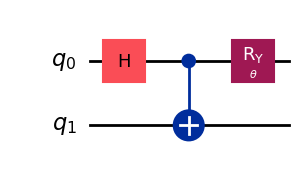

In [ ]:
theta = Parameter("$\\theta$")

chsh_circuit = QuantumCircuit(2)
chsh_circuit.h(0)
chsh_circuit.cx(0, 1)
chsh_circuit.ry(theta, 0)
chsh_circuit.draw(output="mpl", idle_wires=False, style="iqp")

### Create a list of phase values to be assigned later
create a list of 21 phase values range from
0 to
2π with equal spacing, that is,

0,
0.1π,
0.2π, ...,
1.9π,
2π.

Each phase value = one choice of measurement angle (one setting) for qubit 0.

So that we will measure the qubits at specific angles, and it will loop through them

In [ ]:
number_of_phases = 21
phases = np.linspace(0, 2 * np.pi, number_of_phases)
# Phases need to be expressed as list of lists in order to work
individual_phases = [[ph] for ph in phases]

### Observables

It is a mathematical operator whose expectation value you want (like Z, X, Y)

Now we need observables from which to compute the expectation values

Expectation value : average result you would get if you measure something many times.

In [ ]:
# <CHSH1> = <AB> - <Ab> + <aB> + <ab> -> <ZZ> - <ZX> + <XZ> + <XX>
observable1 = SparsePauliOp.from_list(
    [("ZZ", 1), ("ZX", -1), ("XZ", 1), ("XX", 1)]
)

# <CHSH2> = <AB> + <Ab> - <aB> + <ab> -> <ZZ> + <ZX> - <XZ> + <XX>
observable2 = SparsePauliOp.from_list(
    [("ZZ", 1), ("ZX", 1), ("XZ", -1), ("XX", 1)]
)

## Step 2 : Optimize problem for quantum hardware execution

To reduce the total job execution time, V2 primitives only accept circuits and observables that conforms to the instructions and connectivity supported by the target system (referred to as instruction set architecture (ISA) circuits and observables).

### ISA Circuit

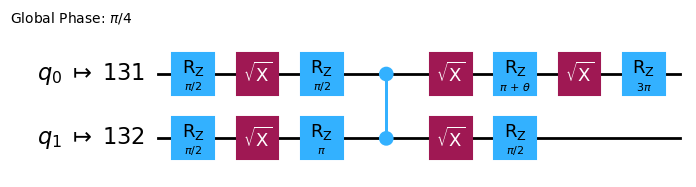

In [ ]:
target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

chsh_isa_circuit = pm.run(chsh_circuit)
chsh_isa_circuit.draw(output="mpl", idle_wires=False, style="iqp")

### ISA Observables
transform the observables to make it backend compatible before running jobs with Runtime Estimator V2. We can perform the transformation using the apply_layout the method of SparsePauliOp object.

In [ ]:
isa_observable1 = observable1.apply_layout(layout=chsh_isa_circuit.layout)
isa_observable2 = observable2.apply_layout(layout=chsh_isa_circuit.layout)

## Step 3: Execute using Qiskit primitives

In order to execute the entire experiment in one call to the Estimator.

We can create a Qiskit Runtime Estimator primitive to compute our expectation values.

The EstimatorV2.run() method takes an iterable of primitive unified blocs (PUBs). Each PUB is an iterable in the format (circuit, observables, parameter_values: Optional, precision: Optional).

In [ ]:
# To run on a local simulator:
# Use the StatevectorEstimator from qiskit.primitives instead.

estimator = Estimator(mode=backend)

pub = (
    chsh_isa_circuit,  # ISA circuit
    [[isa_observable1], [isa_observable2]],  # ISA Observables
    individual_phases,  # Parameter values
)

job_result = estimator.run(pubs=[pub]).result()

Estimator will run the circuit for each phase combination and compute the expectation values.

Its like “Take this one circuit with parameter θ,
and evaluate these observables
for every θ in individual_phases.”

It does

- bind θ = phase[0] → run circuit → compute ⟨CHSH1⟩, ⟨CHSH2⟩

- bind θ = phase[1] → run circuit → compute ⟨CHSH1⟩, ⟨CHSH2⟩

CHSH1 and CHSH2 use the same phase value, but use it in different combination of measurement settings like S1​=⟨AB⟩+⟨Ab⟩+⟨aB⟩−⟨ab⟩ and S2​=⟨AB⟩−⟨Ab⟩+⟨aB⟩+⟨ab⟩

## Step 4 : Post-process and return result in desired classical format

The estimator returns expectation values for both of the observables,

⟨ZZ⟩−⟨ZX⟩+⟨XZ⟩+⟨XX⟩ and
⟨ZZ⟩+⟨ZX⟩−⟨XZ⟩+⟨XX⟩

In [ ]:
chsh1_est = job_result[0].data.evs[0]
chsh2_est = job_result[0].data.evs[1]

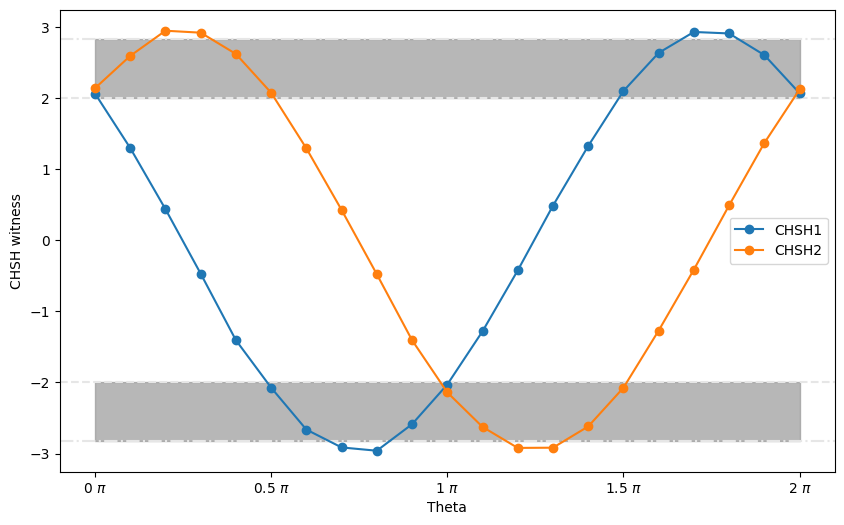

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

# results from hardware
ax.plot(phases / np.pi, chsh1_est, "o-", label="CHSH1", zorder=3)
ax.plot(phases / np.pi, chsh2_est, "o-", label="CHSH2", zorder=3)

# classical bound +-2
ax.axhline(y=2, color="0.9", linestyle="--")
ax.axhline(y=-2, color="0.9", linestyle="--")

# quantum bound, +-2√2
ax.axhline(y=np.sqrt(2) * 2, color="0.9", linestyle="-.")
ax.axhline(y=-np.sqrt(2) * 2, color="0.9", linestyle="-.")
ax.fill_between(phases / np.pi, 2, 2 * np.sqrt(2), color="0.6", alpha=0.7)
ax.fill_between(phases / np.pi, -2, -2 * np.sqrt(2), color="0.6", alpha=0.7)

# set x tick labels to the unit of pi
ax.xaxis.set_major_formatter(tck.FormatStrFormatter("%g $\\pi$"))
ax.xaxis.set_major_locator(tck.MultipleLocator(base=0.5))

# set labels, and legend
plt.xlabel("Theta")
plt.ylabel("CHSH witness")
plt.legend()
plt.show()

In the figure, the lines and gray areas delimit the bounds; the outer-most (dash-dotted) lines delimit the quantum-bounds (
±2), whereas the inner (dashed) lines delimit the classical bounds (
±2 sqrt 2). You can see that there are regions where the CHSH witness quantities exceeds the classical bounds.

## Summary
S1, S2 measure the strength of correlation between two qubits under different measurement settings.

### no entanglement (classical physics)
∣S∣≤2

### Quantum entanglement
2<∣S∣≤2 sqrt 2​≈2.828

If S exceeds 2, the qubits are entangled and showing a correlation pattern that is impossible using classical physics.

### The results
S1
- Peaks around +2.7
- Dips around -2.7

S2
- Does the opposite phase, also reaches about +-2.7. This is normal because the two CHSH forms use different combination of

Both curves go far outside the classical region (+-2)

So, entanglement is present, CHSH inequality is violated AND the bell state shows non-classical correlation